In [1]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [2]:
STOPWORDS = list(set(stopwords.words('english')))

In [3]:
def sanitize_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces

    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords

    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in STOPWORDS]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [4]:
jobs = ["front-end developer", "frontend developer", "senior frontend developer", "junior front-end developer", 
"backend developer", "junior marketing manager", "Front-end Engineer (React)", "Front End Software Engineer", "Frontend Engineer - Commerce",
"Frontend Engineer", "Senior Front-end Engineer - Travel Inventory", "Front End Engineer (Bangkok based – Relocation provided)",
"Sr. Full Stack Engineer", "CEO", "marketing manager", "react developer", "vue developer", "python developer", 
"machine learning engineer", "data scientist", "project manager", "account manager", "senior project manager", "full stack developer", 
"developer full stack python javascript", "data analyst", "senior data scientist", "machine learning specialist", "SEO specialist", 
"javascript developer", "NLP data scientist", "Life coach", "director of research", "product manager", "senior python engineer", 
"lead data scientist", "account manager", "managing partner", "co-founder and learner"]

In [5]:
to_remove = ["junior", "senior", "stage", "sr"]
STOPWORDS.extend(to_remove)

In [6]:
def normalize_role(text):
    roles_to_normalize = [("front end", "frontend"), ("back end", "backend")]
    for wrong, right in roles_to_normalize:
        if wrong in text:
            return right + " " + text[len(wrong) + 1:]
        else:
            return text

In [7]:
normalize_role("back end developer")

'back end developer'

In [8]:
cleaned_jobs = [sanitize_text(job, remove_stopwords=True) for job in jobs]
cleaned_roles = [normalize_role(job) for job in cleaned_jobs]

In [9]:
def run(vectorizer, cleaned_jobs, n_clusters):
    X = vectorizer.fit_transform(cleaned_jobs).toarray()
    voc = vectorizer.get_feature_names()
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    clusters = kmeans.predict(X)

    reduced = PCA(n_components=3).fit_transform(X)
    
    pca_1, pca_2 = reduced[:, 0], reduced[:, 1]
    df = pd.concat([pd.Series(pca_1, name="PCA1"), \
        pd.Series(pca_2, name="PCA2"), \
            pd.Series(clusters, name="cluster")], axis=1)

    print("Top terms per cluster:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(n_clusters):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :1]:
            print(' %s' % voc[ind])

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="cluster", palette="coolwarm")
    for job, (_x, _y) in zip(cleaned_jobs, df[["PCA1", "PCA2"]].values):
        plt.text(_x, _y, job, horizontalalignment='left', size='medium', color='black')
    plt.show()

In [10]:
vecs = [CountVectorizer(ngram_range=(2, 3)), 
TfidfVectorizer(ngram_range=(2, 3))]

VEC: CountVectorizer
Top terms per cluster:
Cluster 0:
 account manager
Cluster 1:
 full stack
Cluster 2:
 data scientist
Cluster 3:
 frontend engineer react
Cluster 4:
 travel inventory
Cluster 5:
 engineer bangkok
Cluster 6:
 co founder
Cluster 7:
 project manager
Cluster 8:
 frontend developer
Cluster 9:
 full stack engineer


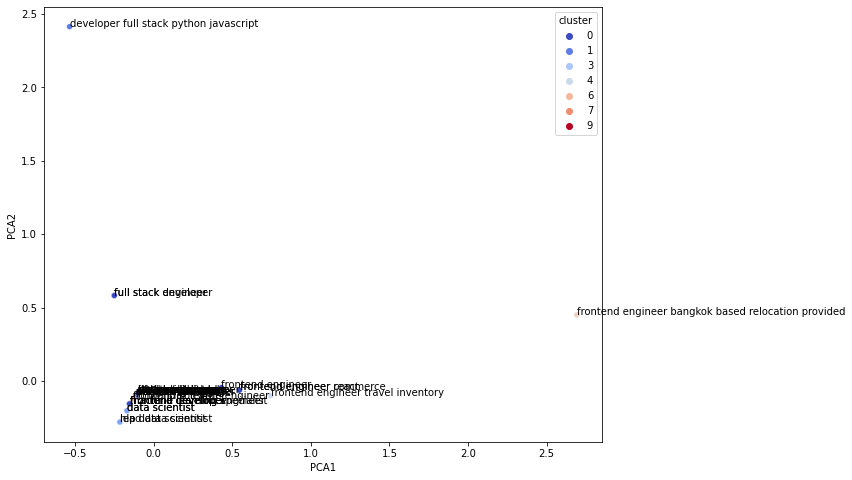

VEC: TfidfVectorizer
Top terms per cluster:
Cluster 0:
 backend developer
Cluster 1:
 data scientist
Cluster 2:
 frontend developer
Cluster 3:
 marketing manager
Cluster 4:
 account manager
Cluster 5:
 frontend engineer
Cluster 6:
 project manager
Cluster 7:
 full stack
Cluster 8:
 machine learning
Cluster 9:
 python engineer


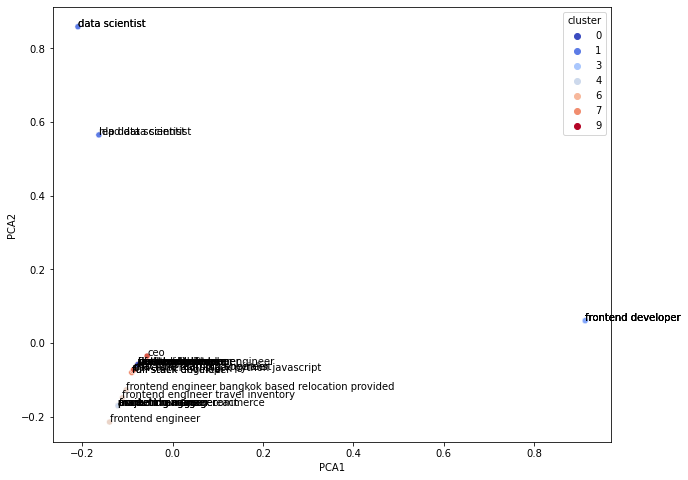

In [12]:
for vec in vecs:
    print(f"VEC: {vec.__class__.__name__}")
    run(vec, cleaned_roles, 10)